In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import tifffile
import torchvision.transforms as transforms
import os

class PairedMedicalSliceDataset(Dataset):
    def __init__(self, us_file_paths, mri_file_paths, num_slices=10, transform=None):
        assert len(us_file_paths) == len(mri_file_paths), "US and MRI file length not match!"

        self.us_file_paths = us_file_paths
        self.mri_file_paths = mri_file_paths
        self.num_slices = num_slices
        self.transform = transform
        self.all_slices = []

        for us_path, mri_path in zip(us_file_paths, mri_file_paths):
            with tifffile.TiffFile(us_path) as us_tif, tifffile.TiffFile(mri_path) as mri_tif:
                us_volume = us_tif.asarray()
                mri_volume = mri_tif.asarray()

                num_total_slices = us_volume.shape[2]
                assert num_total_slices == mri_volume.shape[2], f"{us_path} and {mri_path} slice length not match！"

                mid_start = (num_total_slices // 2) - (num_slices // 2)
                mid_slices = list(range(mid_start, mid_start + num_slices))

                for slice_idx in mid_slices:
                    if 0 <= slice_idx < num_total_slices:
                        self.all_slices.append((us_path, mri_path, slice_idx))

    def __len__(self):
        return len(self.all_slices)

    def __getitem__(self, idx):
        us_path, mri_path, slice_idx = self.all_slices[idx]

        with tifffile.TiffFile(us_path) as us_tif, tifffile.TiffFile(mri_path) as mri_tif:
            us_volume = us_tif.asarray()
            mri_volume = mri_tif.asarray()

            us_slice = us_volume[:, :, slice_idx]
            mri_slice = mri_volume[:, :, slice_idx]

        us_tensor = torch.tensor(us_slice, dtype=torch.float32).unsqueeze(0)
        mri_tensor = torch.tensor(mri_slice, dtype=torch.float32).unsqueeze(0)

        us_tensor = us_tensor / us_tensor.max()
        mri_tensor = mri_tensor / mri_tensor.max()

        if self.transform:
            us_tensor, mri_tensor = self.transform(us_tensor, mri_tensor)

        return us_tensor, mri_tensor


class PairedTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, us, mri):
        state = torch.get_rng_state()
        us = self.base_transform(us)
        torch.set_rng_state(state)
        mri = self.base_transform(mri)
        return us, mri

base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
])

paired_transform = PairedTransform(base_transform)

us_files = [
    "/content/E0_Patient_01_US.tif",
    "/content/E0_Patient_07_US.tif",
    "/content/E0_Patient_12_US.tif",
    "/content/E0_Patient_17_US.tif",
    "/content/E0_Patient_01_US_new.tif",
    "/content/E0_Patient_07_US_new.tif",
    "/content/E0_Patient_14_US_new.tif",
    "/content/E0_Patient_16_US_new.tif",
]
mri_files = [
    "/content/E0_Patient_01_MR.tif",
    "/content/E0_Patient_07_MR.tif",
    "/content/E0_Patient_12_MR.tif",
    "/content/E0_Patient_17_MR.tif",
    "/content/E0_Patient_01_MR_new.tif",
    "/content/E0_Patient_07_MR_new.tif",
    "/content/E0_Patient_14_MR_new.tif",
    "/content/E0_Patient_16_MR_new.tif",
]

us_vad = [
    "/content/E0_Patient_17_US.tif",
]
mri_vad = [
    "/content/E0_Patient_17_MR.tif",
]

us_visual = [
    "/content/E0_Patient_18_US.tif",
]
mri_visual = [
    "/content/E0_Patient_18_MR.tif",
]



batch_size = 1

paired_dataset = PairedMedicalSliceDataset(us_files, mri_files, num_slices=10, transform=paired_transform)
paired_loader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
vad_dataset = PairedMedicalSliceDataset(us_vad, mri_vad, num_slices=10, transform=None)
vad_loader = DataLoader(vad_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
visual_dataset = PairedMedicalSliceDataset(us_visual, mri_visual, num_slices=1, transform=None)
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

sample_batch = next(iter(paired_loader))
ir_sample, vis_sample = sample_batch

print("IR shape:", ir_sample.shape)
print("VIS shape:", vis_sample.shape)

IR shape: torch.Size([1, 1, 128, 128])
VIS shape: torch.Size([1, 1, 128, 128])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftThresholding(nn.Module):
    def __init__(self, theta=0.1):
        super(SoftThresholding, self).__init__()
        self.theta = nn.Parameter(torch.tensor(theta))

    def forward(self, x):
        return torch.sign(x) * torch.maximum(torch.abs(x) - self.theta, torch.tensor(0.0, device=x.device))

class DeepUnfoldingFusion(nn.Module):
    def __init__(self, num_layers=20, input_channels=1, img_size=(128, 128)):
        super(DeepUnfoldingFusion, self).__init__()
        self.num_layers = num_layers
        self.W_t = nn.Conv2d(input_channels, input_channels, kernel_size=1, bias=False)
        self.W_e1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, bias=False)
        self.W_e2 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1, bias=False)
        self.shrinkage = SoftThresholding()

    def forward(self, mri, us):
        x = torch.zeros_like(mri)

        for _ in range(self.num_layers):
            x = self.W_t(x) + self.W_e1(mri) + self.W_e2(us)
            x = self.shrinkage(x)

        return x

In [ ]:
!pip install pytorch-msssim

In [ ]:
import torchvision.models as models

class PerceptualLoss(nn.Module):
    def __init__(self, layer=16):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:layer]
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg.eval()

    def forward(self, fused, target):
        if fused.shape[1] == 1:
            fused = fused.repeat(1, 3, 1, 1)
        if target.shape[1] == 1:
            target = target.repeat(1, 3, 1, 1)

        fused_features = self.vgg(fused)
        target_features = self.vgg(target)
        return torch.nn.functional.l1_loss(fused_features, target_features)

In [ ]:
import torch
import torch.nn.functional as F

def gradient_loss(img):
    def gradient_x(img):
        return img[:, :, 1:, :] - img[:, :, :-1, :]

    def gradient_y(img):
        return img[:, :, :, 1:] - img[:, :, :, :-1]

    loss_x = F.l1_loss(gradient_x(img), torch.zeros_like(gradient_x(img)))
    loss_y = F.l1_loss(gradient_y(img), torch.zeros_like(gradient_y(img)))
    return loss_x + loss_y

perceptual_loss_fn = PerceptualLoss().cuda()

def fusion_loss(fused, ir, vis, alpha=0.5, beta=0.4, gamma=0.2, delta=0.2):

    ssim_loss = 0.5 * (1 - ssim(fused, ir)) + 0.5 * (1 - ssim(fused, vis))
    perceptual_loss = 0.5 * perceptual_loss_fn(fused, ir) + 0.5 * perceptual_loss_fn(fused, vis)
    grad_loss = gamma * (gradient_loss(fused) + gradient_loss(ir) + gradient_loss(vis))
    contrast_loss = delta * (torch.abs(fused.std() - ir.std()) + torch.abs(fused.std() - vis.std()))
    mse_loss = 0.5 * F.mse_loss(fused, ir) + 0.5 * F.mse_loss(fused, vis)

    return  mse_loss

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 000/100  Train Loss: 0.0314  Val Loss:   0.2872  LR:         1.00e-03
Epoch 010/100  Train Loss: 0.0230  Val Loss:   0.2773  LR:         1.00e-03
Epoch 020/100  Train Loss: 0.0228  Val Loss:   0.2761  LR:         1.00e-03
Epoch 030/100  Train Loss: 0.0223  Val Loss:   0.2757  LR:         1.00e-03
Epoch 040/100  Train Loss: 0.0232  Val Loss:   0.2754  LR:         1.00e-03
Epoch 050/100  Train Loss: 0.0232  Val Loss:   0.2752  LR:         1.00e-03
Epoch 060/100  Train Loss: 0.0240  Val Loss:   0.2751  LR:         1.00e-03
Epoch 070/100  Train Loss: 0.0246  Val Loss:   0.2751  LR:         1.00e-03
Epoch 080/100  Train Loss: 0.0233  Val Loss:   0.2751  LR:         1.00e-03
Epoch 090/100  Train Loss: 0.0238  Val Loss:   0.2751  LR:         5.00e-04


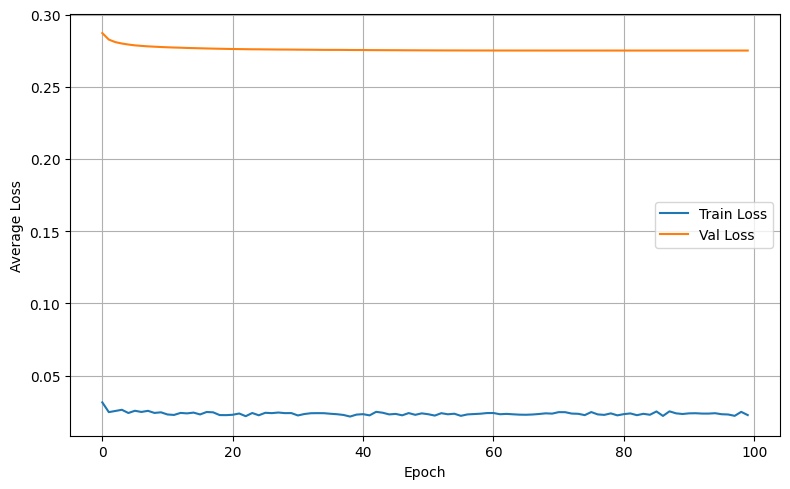

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from pytorch_msssim import ssim

# learning_rate = 1e-3
# num_epochs = 100
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = DeepUnfoldingFusion().to(device)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# for epoch in range(num_epochs):
#     total_loss = 0
#     model.train()
#     for us_batch, mri_batch in paired_loader:
#         us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

#         optimizer.zero_grad()
#         x_fused = model(us_batch, mri_batch)
#         loss = fusion_loss(x_fused, mri_batch, us_batch)

#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     scheduler.step(total_loss / len(paired_loader))

#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss / len(paired_loader)}, LR: {optimizer.param_groups[0]['lr']}")


learning_rate = 1e-3
num_epochs     = 100
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model     = DeepUnfoldingFusion().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 mode='min',
                                                 factor=0.5,
                                                 patience=20,
                                                 verbose=True)

train_loss_history = []
val_loss_history   = []

for epoch in range(num_epochs):
    model.train()
    total_train = 0.0
    for us_batch, mri_batch in paired_loader:
        us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)
        optimizer.zero_grad()
        x_fused = model(us_batch, mri_batch)
        loss    = fusion_loss(x_fused, mri_batch, us_batch)
        loss.backward()
        optimizer.step()
        total_train += loss.item()
    avg_train = total_train / len(paired_loader)
    train_loss_history.append(avg_train)

    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for us_batch, mri_batch in vad_loader:
            us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)
            x_fused = model(us_batch, mri_batch)
            loss    = fusion_loss(x_fused, mri_batch, us_batch)
            total_val += loss.item()
    avg_val = total_val / len(vad_loader)
    val_loss_history.append(avg_val)

    scheduler.step(avg_val)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}/{num_epochs}  "
              f"Train Loss: {avg_train:.4f}  "
              f"Val Loss:   {avg_val:.4f}  "
              f"LR:         {optimizer.param_groups[0]['lr']:.2e}")

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import cv2

def gradient_magnitude_orientation(img):
    gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    G = np.sqrt(gx**2 + gy**2)
    phi = np.arctan2(gy, gx)  
    return G, phi

def xydeas_petrovic(fused, img1, img2, eps=1e-12):
    fused = fused.astype(np.float64)
    img1  = img1.astype(np.float64)
    img2  = img2.astype(np.float64)

    Gf, Phif = gradient_magnitude_orientation(fused)
    G1, Phi1 = gradient_magnitude_orientation(img1)
    G2, Phi2 = gradient_magnitude_orientation(img2)

    Gmax12 = np.maximum(G1, G2)

    Sg1 = (Gf + eps) / (G1 + eps) 
    Sg2 = (Gf + eps) / (G2 + eps)  

    So1 = 1.0 - np.abs(Phif - Phi1) / (np.pi)  
    So2 = 1.0 - np.abs(Phif - Phi2) / (np.pi)

    W1 = G1 / (G1 + G2 + eps)
    W2 = G2 / (G1 + G2 + eps)

    Q1 = Sg1 * So1
    Q2 = Sg2 * So2

    Qfuse = W1 * Q1 + W2 * Q2
    E_score = np.mean(Qfuse)
    return E_score


In [ ]:
def local_stats(arr, window_size=3):
    kernel = np.ones((window_size, window_size), dtype=np.float64) / (window_size**2)
    mean = cv2.filter2D(arr, -1, kernel)
    mean_sq = cv2.filter2D(arr*arr, -1, kernel)
    var = mean_sq - mean**2
    return mean, var

def Q0_metric(fused, img1, img2, window_size=3):
    fused  = fused.astype(np.float64)
    img1   = img1.astype(np.float64)
    img2   = img2.astype(np.float64)

    f_mean, f_var = local_stats(fused, window_size)
    i1_mean, i1_var = local_stats(img1, window_size)
    i2_mean, i2_var = local_stats(img2, window_size)

    w1 = i1_var / (i1_var + i2_var + 1e-12)
    w2 = i2_var / (i1_var + i2_var + 1e-12)

    part1 = w1 * ((2*(f_mean*i1_mean)+1e-12)/(f_mean**2 + i1_mean**2 +1e-12)) \
            + w2 * ((2*(f_mean*i2_mean)+1e-12)/(f_mean**2 + i2_mean**2 +1e-12))

    part2 = w1 * ((2*np.sqrt(f_var*i1_var)+1e-12)/(f_var + i1_var +1e-12)) \
            + w2 * ((2*np.sqrt(f_var*i2_var)+1e-12)/(f_var + i2_var +1e-12))

    Q0_map = part1 * part2

    Q0_score = np.mean(Q0_map)
    return Q0_score


In [ ]:
def piella_Q_metric(fused, img1, img2, window_size=3):
    fused = fused.astype(np.float64)
    img1  = img1.astype(np.float64)
    img2  = img2.astype(np.float64)

    def local_variance(x):
        m, v = local_stats(x, window_size)
        return v
    var1 = local_variance(img1)
    var2 = local_variance(img2)

    W1 = var1 / (var1 + var2 + 1e-12)
    W2 = var2 / (var1 + var2 + 1e-12)

    f_mean, f_var = local_stats(fused, window_size)
    i1_mean, i1_var = local_stats(img1, window_size)
    i2_mean, i2_var = local_stats(img2, window_size)

    corr_f1 = (cv2.filter2D(fused * img1, -1, np.ones((window_size,window_size))/(window_size**2))
               - f_mean*i1_mean) / (np.sqrt(f_var*i1_var)+1e-12)
    corr_f2 = (cv2.filter2D(fused * img2, -1, np.ones((window_size,window_size))/(window_size**2))
               - f_mean*i2_mean) / (np.sqrt(f_var*i2_var)+1e-12)

    Q_map = W1 * corr_f1 + W2 * corr_f2

    Q_score = np.mean(Q_map)
    return Q_score


Petrovic E:  0.5635
Wang Q0:    0.0199
Piella Q:    0.8522


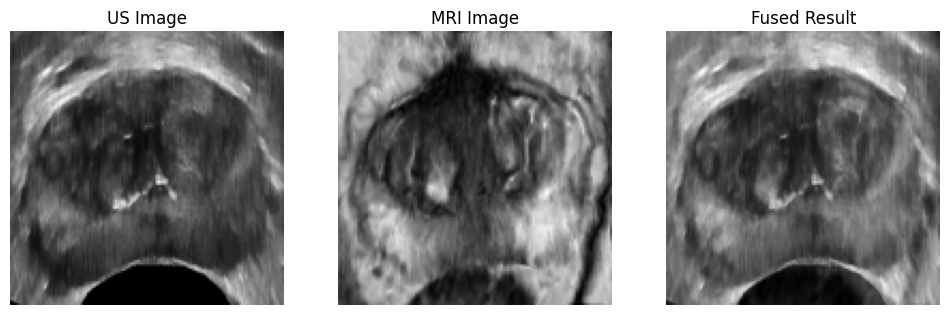

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_fusion(model, paired_loader, device):
    model.eval()

    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        fused_result = model(us_batch, mri_batch)

    us_image = us_batch[0, 0].cpu().numpy()
    mri_image = mri_batch[0, 0].cpu().numpy()
    fused_image = fused_result[0, 0].cpu().numpy()

    E_val   = xydeas_petrovic(fused_image, mri_image, us_image)
    Q0_val  = Q0_metric(fused_image, mri_image, us_image)
    Q_val   = piella_Q_metric(fused_image, mri_image, us_image)

    print(f"Petrovic E:  {E_val:.4f}")
    print(f"Wang Q0:    {Q0_val:.4f}")
    print(f"Piella Q:    {Q_val:.4f}")

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(us_image, cmap='gray')
    ax[0].set_title("US Image")
    ax[0].axis("off")

    ax[1].imshow(mri_image, cmap='gray')
    ax[1].set_title("MRI Image")
    ax[1].axis("off")

    ax[2].imshow(fused_image, cmap='gray')
    ax[2].set_title("Fused Result")
    ax[2].axis("off")

    plt.show()

visualize_fusion(model, visual_loader, device)




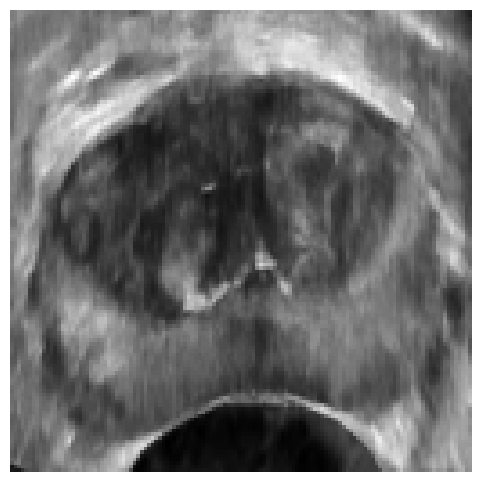

In [ ]:
def visualize_fusion(model, paired_loader, device):
    model.eval()

    us_batch, mri_batch = next(iter(paired_loader))
    us_batch, mri_batch = us_batch.to(device), mri_batch.to(device)

    with torch.no_grad():
        fused_result = model(us_batch, mri_batch)

    fused_image = fused_result[0, 0].cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(fused_image, cmap='gray')
    plt.axis("off")
    plt.show()

visualize_fusion(model, visual_loader, device)